In [103]:
import numpy as np
from scipy.sparse import csgraph

import matplotlib.pyplot as plt

In [104]:
from graph_laplacian.commuting_operations_experiments import get_experiments, main

In [190]:
def get_grid_adjaceny_matrix(n):
    mat = np.zeros((n*n,n*n))
    for row in range(n):
        for col in range(n):
            vertex_index = n*row + col

            neighbour_index_dict = {}

            neighbour_index_dict['right'] = n * row + (col + 1) % n
            neighbour_index_dict['left'] = n * row + (col - 1) % n
            neighbour_index_dict['up'] = n * ((row - 1) % n) + col
            neighbour_index_dict['down'] = n * ((row + 1) % n) + col

            for direction, neighbour_index in neighbour_index_dict.items():
                mat[vertex_index, neighbour_index] = 1
                mat[neighbour_index, vertex_index] = 1
    return mat


In [191]:
get_grid_adjaceny_matrix(3)

array([[0., 1., 1., 1., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 1., 1., 1., 0.]])

In [192]:
def discretise_function(f, resolution):
    n = resolution

    # np.fromfunction doesn't work when applied to weird functions
    f_disc = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            f_disc[i][j] = f(j/n, i/n)

    return f_disc


In [193]:
def discrete_laplacian_eigenfunction(n, period1, period2):
    f = np.empty((n, n), dtype=np.complex)  # important to set the dtype to complex!
    for i in range(n):
        for j in range(n):
            f[i][j] = np.exp(2j * np.pi * (j * period1 / n + i * period2 / n))
    return f / np.linalg.norm(f)  # use linalg norm to get the correct norm of compex vector

In [194]:
x = np.random.randn(25)

In [195]:
np.linalg.norm(discrete_laplacian_eigenfunction(5, 2, 3))

1.0

In [196]:
def get_graph_laplacian_eigenbasis(n, flavour='fourier_series'):
    if flavour == 'fourier_series':
        basis = []
        for k in range(n):
            for l in range(n):
                basis += [discrete_laplacian_eigenfunction(n, k, l).reshape(-1)]
        return np.array(basis)
    elif flavour == 'scipy':
        G = get_grid_adjaceny_matrix(n)
        L = csgraph.laplacian(G, normed=False)
        basis = np.transpose(np.linalg.eig(L)[1]) # after transposing rows are eigenvectors
        return basis

In [197]:
get_graph_laplacian_eigenbasis(2, flavour="fourier_series")

array([[ 0.5+0.0000000e+00j,  0.5+0.0000000e+00j,  0.5+0.0000000e+00j,
         0.5+0.0000000e+00j],
       [ 0.5+0.0000000e+00j,  0.5+0.0000000e+00j, -0.5+6.1232340e-17j,
        -0.5+6.1232340e-17j],
       [ 0.5+0.0000000e+00j, -0.5+6.1232340e-17j,  0.5+0.0000000e+00j,
        -0.5+6.1232340e-17j],
       [ 0.5+0.0000000e+00j, -0.5+6.1232340e-17j, -0.5+6.1232340e-17j,
         0.5-1.2246468e-16j]])

In [198]:
get_graph_laplacian_eigenbasis(2, flavour="scipy")

array([[-5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
        -5.00000000e-01],
       [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
         5.00000000e-01],
       [ 7.07106781e-01,  4.80181756e-16, -1.77321568e-16,
        -7.07106781e-01],
       [ 4.08248290e-01, -5.77350269e-01,  5.77350269e-01,
        -4.08248290e-01]])

In [199]:
# np.dot(1j, np.conjugate(1j))

# G = get_grid_adjaceny_matrix(4)
# L = csgraph.laplacian(G, normed=False)
# np.linalg.eig(L)

In [200]:
a = np.arange(10).reshape(2, 5)
b = np.array([10, 20]).reshape(-1, 1)
a, b

(array([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]]),
 array([[10],
        [20]]))

In [201]:
b * a#.sum(axis=0)

array([[  0,  10,  20,  30,  40],
       [100, 120, 140, 160, 180]])

In [202]:
def graph_convolve(f, g, flavour='fourier_series'):
    assert f.shape == g.shape # input same size?
    assert f.shape[0] == f.shape[1] # square matrix?
    n = f.shape[0]

    eigenvectors = get_graph_laplacian_eigenbasis(n, flavour)

    coeffs_f = np.dot(eigenvectors.conjugate(), f.reshape(-1, 1))
    coeffs_g = np.dot(eigenvectors.conjugate(), g.reshape(-1, 1))
    assert coeffs_f.shape == coeffs_g.shape == (n**2, 1)
    
    f_conv_g = (coeffs_f * coeffs_g * eigenvectors).sum(axis = 0).reshape(n, n)
    np.testing.assert_allclose(f_conv_g.imag, 0.0, rtol=0, atol=1e-10)
    
    return f_conv_g.real

#     for num, v in enumerate(eigenvectors):
#         vec = np.reshape(v, -1)
#         proj['f'] += [np.dot(vec, np.conjugate(f))]
#         proj['g'] += [np.dot(vec, np.conjugate(g))]
#         proj['f_conv_g'] += [np.dot(vec, f) * np.dot(vec, g)]

#     f_conv_g = [p * vec for p, vec in zip(proj['f_conv_g'], eigenvectors)]
#     f_conv_g = np.sum(f_conv_g, axis=0)
#     f_conv_g = np.real(f_conv_g)
#     f_conv_g = np.reshape(f_conv_g, (n, n))

In [203]:
def smooth_convolve(f, g, resolution):
    n = resolution

    def fg_function(x, y):
        f_matrix = np.fromfunction(lambda i, j: f(j / n, i / n), (n, n))  # columns=x-coordinate
        g_matrix = np.fromfunction(lambda i, j: g(j / n, i / n), (n, n))

        g_matrix = np.roll(np.flip(g_matrix), 1)
        g_matrix = np.roll(g_matrix, int(np.round(x*n)), axis=1)
        g_matrix = np.roll(g_matrix, int(np.round(y*n)), axis=0)

        fg_matrix = f_matrix * g_matrix

        return np.sum(fg_matrix) / n**2
    return fg_function


In [204]:
experiment_pairs = [
        (
            lambda x, y: np.cos(2 * np.pi * x),
            lambda x, y: np.cos(2 * np.pi * x) + np.cos(4 * np.pi * x)
        ),
        (
            lambda x, y: np.cos(2 * np.pi * x),
            lambda x, y: np.cos(2 * np.pi * y)
        ),
        (
            lambda x, y: np.cos(2 * np.pi * x),
            lambda x, y: np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)
        ),
        (
            lambda x, y: np.cos(2 * np.pi * x),
            lambda x, y: 1 + 0 * x
        ),
        (
            lambda x, y: (x - 0.5) ** 2 + (y - 0.5) ** 2,
            lambda x, y: np.cos(4 * np.pi * x) + np.cos(4 * np.pi * y)
        ),
        (
            lambda x, y: (x - 0.5) ** 2 + (y - 0.5) ** 2,
            lambda x, y: x + y
        ),
    ]

In [205]:
def discretise_graph_convolve(f, g, n, flavour):
    f_matrix = discretise_function(f, n)
    g_matrix = discretise_function(g, n)
    
    return graph_convolve(f_matrix, g_matrix, flavour)

def smooth_convolve_discretise(f, g, n, convolution_resolution):
    
    f_conv_g = smooth_convolve(f, g, convolution_resolution)
    return discretise_function(f_conv_g, n)
    

In [206]:
def plot_discrete_function(f):
    assert f.shape[0] == f.shape[1] # square matrix?
    plt.imshow(f)
    plt.colorbar()
    plt.show()


def plot_discrete_function_multiple(functions, rescale_minimum=1):
    plt.figure()
    _, axarr = plt.subplots(1, len(functions))

    for num, f in enumerate(functions):
        if isinstance(f, tuple):
            axarr[num].set_title(f[1])
            f = f[0]
        f_max = max(rescale_minimum, np.max(f))
        f_min = min(rescale_minimum, np.min(f))

        axarr[num].imshow(f, vmin=f_min, vmax=f_max)

    plt.show()

<Figure size 432x288 with 0 Axes>

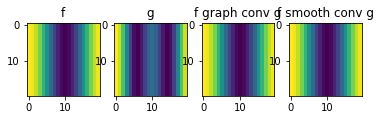

<Figure size 432x288 with 0 Axes>

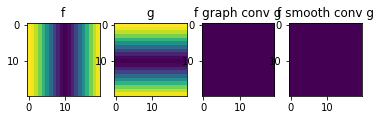

<Figure size 432x288 with 0 Axes>

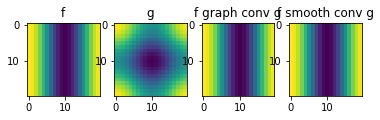

<Figure size 432x288 with 0 Axes>

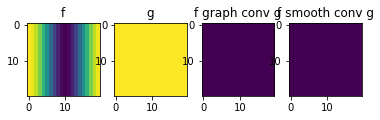

<Figure size 432x288 with 0 Axes>

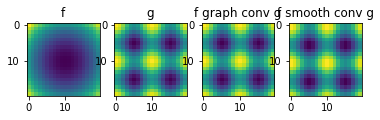

<Figure size 432x288 with 0 Axes>

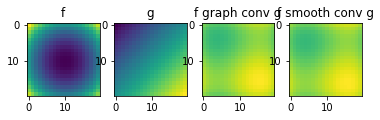

In [207]:
flavour = "fourier_series"
experiment_pairs = get_experiments()
n = 20  

for f, g in experiment_pairs[:]:
    path1_conv = discretise_graph_convolve(f, g, n, flavour)  # can choose 'scipy' instead
    path2_conv = smooth_convolve_discretise(f, g, n, convolution_resolution=40)
    
    plot_discrete_function_multiple(
        [
            (discretise_function(f, n), 'f'),
            (discretise_function(g, n), 'g'),
            (path1_conv, 'f graph conv g'),
            (path2_conv, 'f smooth conv g')
        ],
        rescale_minimum=0.0001
    )

In [170]:
a = np.zeros(10)